# Case Studies Assignment 2

### Group Members: Shreya Nagarkar(17231663) and Riti Chakraborty(17231417)

<br><br>
### Task	1	- Determining	the	trending	policy topics in	Galway	based	on	analysis	of	Facebook	pages	or	tweets	from	Local	Media	house	(Newspaper	or	Radio	station). Facebook data is used for this assignment.


#### Importing the required libraries here:

In [1]:

#for reading json file
import json

#for handling date and time
import datetime
import time
import calendar

#for reading and writing into csv file
import csv

#for requesting an URL and fetching data
import urllib.request

#for handling dataframes
import pandas as pd
from itertools import chain

#for treemap
import squarify

#for plots
import matplotlib.pyplot as plt
import plotly
import numpy as np


## Task 1: Accessing Facebook Data

In [2]:
###################################### Riti ###############################################################################

#Access token to fetch from Facebook
access_token ="203760660382790|4aPBk0cVP4ztPt-q17f_l8K0xDQ"
#print(access_token)
#ID of local facebook Page which is used to fetch data.
page_ID="GalwayAdvertiser"
#Check for occurence of exception. Sometime the URL doesnot connect easily and gives error. 
#This part of the code tries to reconnect to the server until successful.
def request(url):
    req = urllib.request.Request(url)
    success = False
    while success is False:
        try: 
            response = urllib.request.urlopen(req)
            #If the connection is successful the returned code is 200 else 404
            if response.getcode() == 200:
                success = True
        except (Exception, e):
            time.sleep(5)
            print ("Error for URL %s: %s" % (url))

    return response.read()

Here we are handling the Date obtained from the Facebook and bringing it to a format that will be easy to read on excel file. writerow() takes only one argument (mentioned in the cell below). Therefore, a seperate function, process_FB_Data() is created to format the posts and the date&time after seperation and is returned as a Tuple.

This is the main function which is used to fetch data of the past 6 months using the specific query stated in the 'url' variable.
#### Maximum 100 posts are displayed per page, the remaining posts are displayed in next pages. Each page has a paging section. This section contains the link to the next page contaning the remaining 100 data. Here i am checking if a page has the 'next' link in the Paging Section and pinging that URL to fetch more data.

In [3]:
###################################### Riti ###############################################################################
# Formatting data before storing
def process_FB_Data(status):
    
    #formatting the message
    post_on_page = '' if 'message' not in status.keys() else status['message'].encode('utf-8') 
    
    #formatting the date
    page_published = datetime.datetime.strptime(status['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
    page_published = page_published + datetime.timedelta(hours=-5) # EST
    page_published = page_published.strftime('%Y-%m-%d %H:%M:%S') # best time format for spreadsheet programs
    
    #returning results
    return (post_on_page, page_published)
#The main function to fetch the data from facebook.
def FetchdataFB(page_id):
    #Fecthing and storing the data into a CSV file
    with open('facebook_page_statuses.csv', 'w') as file:
        #Writing the data into the file
        w = csv.writer(file)
        next_page = True
        no_of_post_fetched = 0
        #Storing the URL with all the required fields.
        url="https://graph.facebook.com/GalwayAdvertiser/posts/?fields=message,created_time,id&limit=100&access_token=203760660382790|4aPBk0cVP4ztPt-q17f_l8K0xDQ&since=20+oct+2017&until=23+march+2018&limit=100"
        #Data is fetched in the json format.
        data = json.loads(request(url))
        posts=data
        #Accessing the next page
        while next_page:
           #The data is stored in the form of Dictionary. There going to the required level of the dictionary and fetching the next link
           #Storing the data 
            for i in posts['data']:
                w.writerow(process_FB_Data(i))
                no_of_post_fetched += 1
            #Checking for 'next' page links.
            if 'paging' in posts.keys():
                if 'next' in posts['paging'].keys():
                    next_link=posts['paging']['next']
                    
                    #Calling the hadling exception function.
                    posts = json.loads(request(next_link))
                else:
                    next_page = False
        #Printing total number of Posts fetched
        print (" %s Posts Fetched"%(no_of_post_fetched))


FetchdataFB(page_ID)

#Opening the File created above. It contains two fields: Posts and Created Time and Date
FB_data = pd.read_csv("facebook_page_statuses.csv",header=None)

#dropping the fields containing NA
FB_data=FB_data.dropna()

#renaming the columns
FB_data = FB_data.rename(columns={0:'Posts', 1:'DateTime'})

#Printing the Data accessed
print(FB_data)

 680 Posts Fetched
                                                 Posts             DateTime
0    b'\xe2\x80\xaaSad news from Ballinasloe tonigh...  2018-03-22 16:28:59
1    b'\xe2\x80\x9cMy favourite time in Galway is t...  2018-03-22 14:55:00
2    b"*** It's here, Caprice's brand new night tim...  2018-03-22 12:10:00
3    b'Do you have a family history of Osteoporosis...  2018-03-22 11:30:00
4    b"Fine Gael are doing well in the polls, Fiann...  2018-03-22 10:35:00
5    b'A refurbished orthopaedic operating theatre ...  2018-03-22 06:45:00
6    b'A spate of vandalism at the former Gaelscoil...  2018-03-22 03:50:00
7    b'Good morning Galway. Our lead story: A racis...  2018-03-22 02:56:29
8    b"Skin Herbalist - Patrick Murphy has launched...  2018-03-21 15:53:00
9    b"ConTempo String Quartet and RT\xc3\x89's Vin...  2018-03-21 13:43:00
10   b'HotelMeyrick Galway is celebrating Easter an...  2018-03-21 07:15:00
11   b'Have you been to see Cillian Murphy in Grief...  2018-03-21 05

File: facebook_page_statuses.csv contains the data fetched from facebook using the Access token and queries

### Task 2 and Task 3: Identifying	relevant	posts		from	those	obtained previously and Analysis	of	the	relevant	posts	to	determine	to	provide	required	information	(counts	of	posts per	policy area)	

#### Defining a Function for (counts	of	posts per	policy area). The Keywords chosen belong to three different policies.  

1. The file read below i.e one_Key.txt contains kewords related to weather Policy.
2. The file housing_key.txt contains keywords which are related to housing/Accomodation Policy.
3. The file Events.txt contains keywords which are related to any Events Public or Social gatherings Policy
3. The function below takes up the Policy name and the file name as argument.

In [4]:
#################################### Shreya #####################################################################

#Defining Function to count relevant posts with respect to the policy keywords
def Count(Policy, filename):
    #For Storing the resulting relevant posts
    res_1=[]
    
    #For storing the corresponding keywords
    key_1=[]
    
    #Creating a Temporary array to store the keywords.
    temp_pool=[]
    
    #Creating a dictionary
    dict={}
    
    #It opens the file which is passed as an argument.
    with open(filename) as f:
        
        #Reading the contents of the file
        data = f.readlines()
        
        #Removing \n if it appears in the file of keywords
        line = [i.replace('\n','') for i in data]
        
        #Manually tokenizing the words and removing the trailing spaces
        for i in line:
            #Storing the token into the temp_pool list
            temp_pool.append(i.rstrip().split(" "))
            
    #Storing the clean keywords.
    Keywords_pool=list(chain(*temp_pool))
    
    #Fetching the Posts from the Main Database which contains the facebook data.
    Posts_list=list(FB_data['Posts'])
    
    #Defining empty list to store the matching keyword and the matching post.
    match_keyword=[]
    relevant_post=[]

    #Checking for occurance of keyword in the posts.
    for i in Posts_list:
        for j in Keywords_pool:
            if j in i:
                #Storing tnhe matched Keywords and the corresponding Posts
                match_keyword.append(j)
                relevant_post.append(i)
    
    #Removing Duplicates if present.
    relevant_post=set(relevant_post)
    match_keyword=set(match_keyword)
    
    #Defining empty lists.
    #Storing the Statistics of the keyword from the pool of Relevant Keywpords.
    keyw=[]
    l=[]
    posts=[]
    posts_df=[]
    
    #Subsetting relevant posts and then storing them along with the policy, count, keyword and the posts.
    for i in match_keyword:
        count=0
        tup=()
        for j in relevant_post:
            j.lower()
            if i in j:
                
                #Storing the relevant Posts
                #posts.append(j)
                count=count+1
                res_1.append(j)
                key_1.append(i)
                
        #creating a Tuple to store the Keyword and its corresponding Count.
        tup=(i,count)
        
        #Copnverting the Tuple into a list
        l.append(tup)
        
    #Updating the Dictionary
    dict.update({Policy:l})
    
    #Creating a Dataframe of the Relevant Posts
    Result = pd.DataFrame({'Keyword': key_1,'Post': res_1})
    
    
    #Storing the relevant posts in a CSV file
    Result.to_csv('Relevant_Post1.csv', header=True, index=False)
    
    #Returning the Dictionary and the relevant posts
    return(dict,Result)



In [5]:
########################################### Riti ##################################################################

#Calling the function Created above which each of the keywords file

#Calling the functions with the policy of keywords in the weather policy
Weather_1=Count('Weather', 'one_Key.txt')
L = [(k, *t) for k, v in Weather_1[0].items() for t in v]
dframe1 = pd.DataFrame(L, columns=['Policy','Keywords','No_of_Posts_with_Keyword'])
dframe1=dframe1.sort_values('No_of_Posts_with_Keyword',  ascending=False)


#Calling the functions with the policy of keywords in the Housing policy
Housing_1=Count('Housing', 'housing_key.txt')
L = [(k, *t) for k, v in Housing_1[0].items() for t in v]
dframe2 = pd.DataFrame(L, columns=['Policy','Keywords','No_of_Posts_with_Keyword'])
dframe2=dframe2.sort_values('No_of_Posts_with_Keyword',  ascending=False)

#Calling the functions with the policy of keywords in the Events policy
Events_1=Count('Events', 'Events.txt')
L = [(k, *t) for k, v in Events_1[0].items() for t in v]
dframe3 = pd.DataFrame(L, columns=['Policy','Keywords','No_of_Posts_with_Keyword'])
dframe3=dframe3.sort_values('No_of_Posts_with_Keyword',  ascending=False)

#Combining the rsults obtained above in one single dataframe 
frames=[dframe1,dframe2,dframe3]
final_table = pd.concat(frames)
final_table_sorted=final_table.sort_values('No_of_Posts_with_Keyword',  ascending=False)
final_table_sorted=final_table_sorted[1:]
#Exporting into CSV file
final_table_sorted.to_csv('All.csv', header=True)

#Exporting top 20 records into csv file
final_table_sorted_top20=final_table_sorted.iloc[1:20,]
final_table_sorted_top20.to_csv('top_20.csv', header=True)

#Printing top 20 records.
print(final_table_sorted_top20)

     Policy    Keywords  No_of_Posts_with_Keyword
8    Events        time                        50
11  Weather         air                        37
9   Housing        rent                        33
22  Weather        snow                        32
16  Weather        heat                        31
18   Events       event                        30
31  Weather     weather                        28
11  Housing        home                        22
15  Housing    business                        22
20  Weather        rain                        17
10  Housing       house                        16
7   Weather       flood                        16
26  Weather        wind                        16
2   Weather         hot                        15
5    Events        full                        15
6   Housing  properties                        14
4   Housing        room                        12
7   Housing         bed                        11
17   Events        ball                        11


### Task 4: Visualisation


### 1. Donut Chart

Donut chart, that is multilayer pie chart below is the visualization of distribution relevant keywords towards policies. The more the size and the more the darker colour of the slice in the pie, the more contribution of the keyword towards the policy.

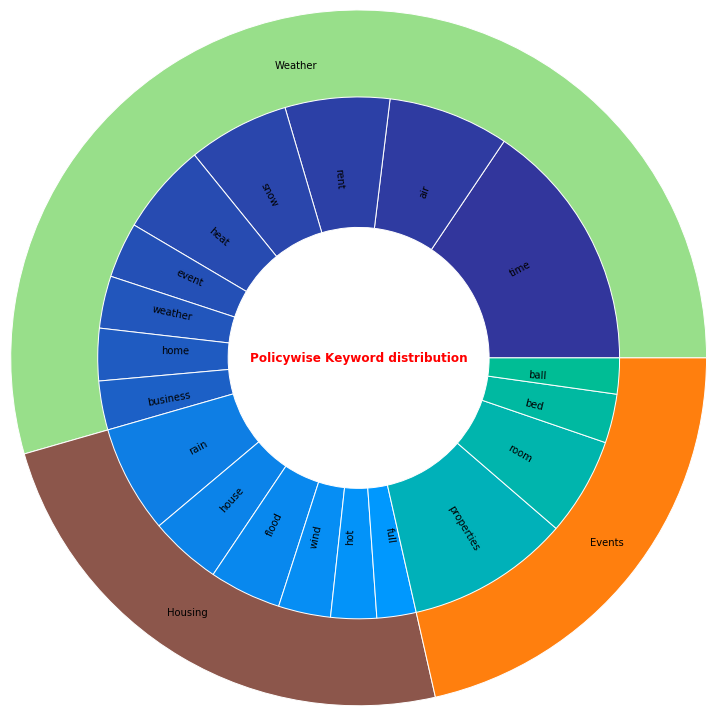

In [6]:
######################################## Shreya #################################################################

import matplotlib.pyplot as plt
# frames = [dframe1, dframe2[1:], dframe3]
# final_df = pd.concat(frames, ignore_index=True)
# final_df
# Group names is the list of policy names which is nothing but the outer layer of the pie chart
group_names=['Weather', 'Housing', 'Events']

# The values in the below group_size list are the total counts of keywords belonging to that particular policy
group_size=[269,119,106]

subgroup_names=final_table_sorted_top20['Keywords'].tolist()
# Subgroup size is the list of counts of keywords aranged in the order of the policy
subgroup_size=[77,37,32,31,28,17,16,16,15,33,22,22,16,14,12,50,30,15,11]

# Creating colors
# The colours are selection by selecting the pallate and shade is selected by the number mentioned. More the number, lighter the shade.
cm = plt.get_cmap("terrain")
cin = cm(np.array([1,2,3,4,5,6,7,8,9,28,29,30,31,32,33,50,51,52,53]))
cin = cm(np.array([1,3,5,7,9,11,13,15,17,28,30,32,34,36,38,50,52,54,56]))


cm1 = plt.get_cmap("tab20")

# Outer pie chart
fig, ax = plt.subplots()
ax.axis('equal')
colors=cm1(np.array([5,10,2]))
mypie, _ = ax.pie(group_size, radius=4, labels=group_names, colors=colors,labeldistance=0.85)
plt.setp( mypie, width=1.5, edgecolor='white')
 
# Inner pie chart
mypie2, _ = ax.pie(subgroup_size, radius=3, labels=subgroup_names,labeldistance=0.65, rotatelabels=90,colors=cin)
plt.setp( mypie2, width=1.5, edgecolor='white')
plt.margins(0,0)
kwargs = dict(size=12, fontweight='bold', va='center', color="Red")
ax.text(0, 0, "Policywise Keyword distribution", ha='center', **kwargs)

# Visualization            
plt.show()


### 2. Treemap

Treemap below is the visulization of the overall keywords belonging to the policy. 
The yellow colour represents the Weather polict whereas purple represents housing followed by events in pink. 
Size of the box is nothing but the representation of the keywords towards the policy.

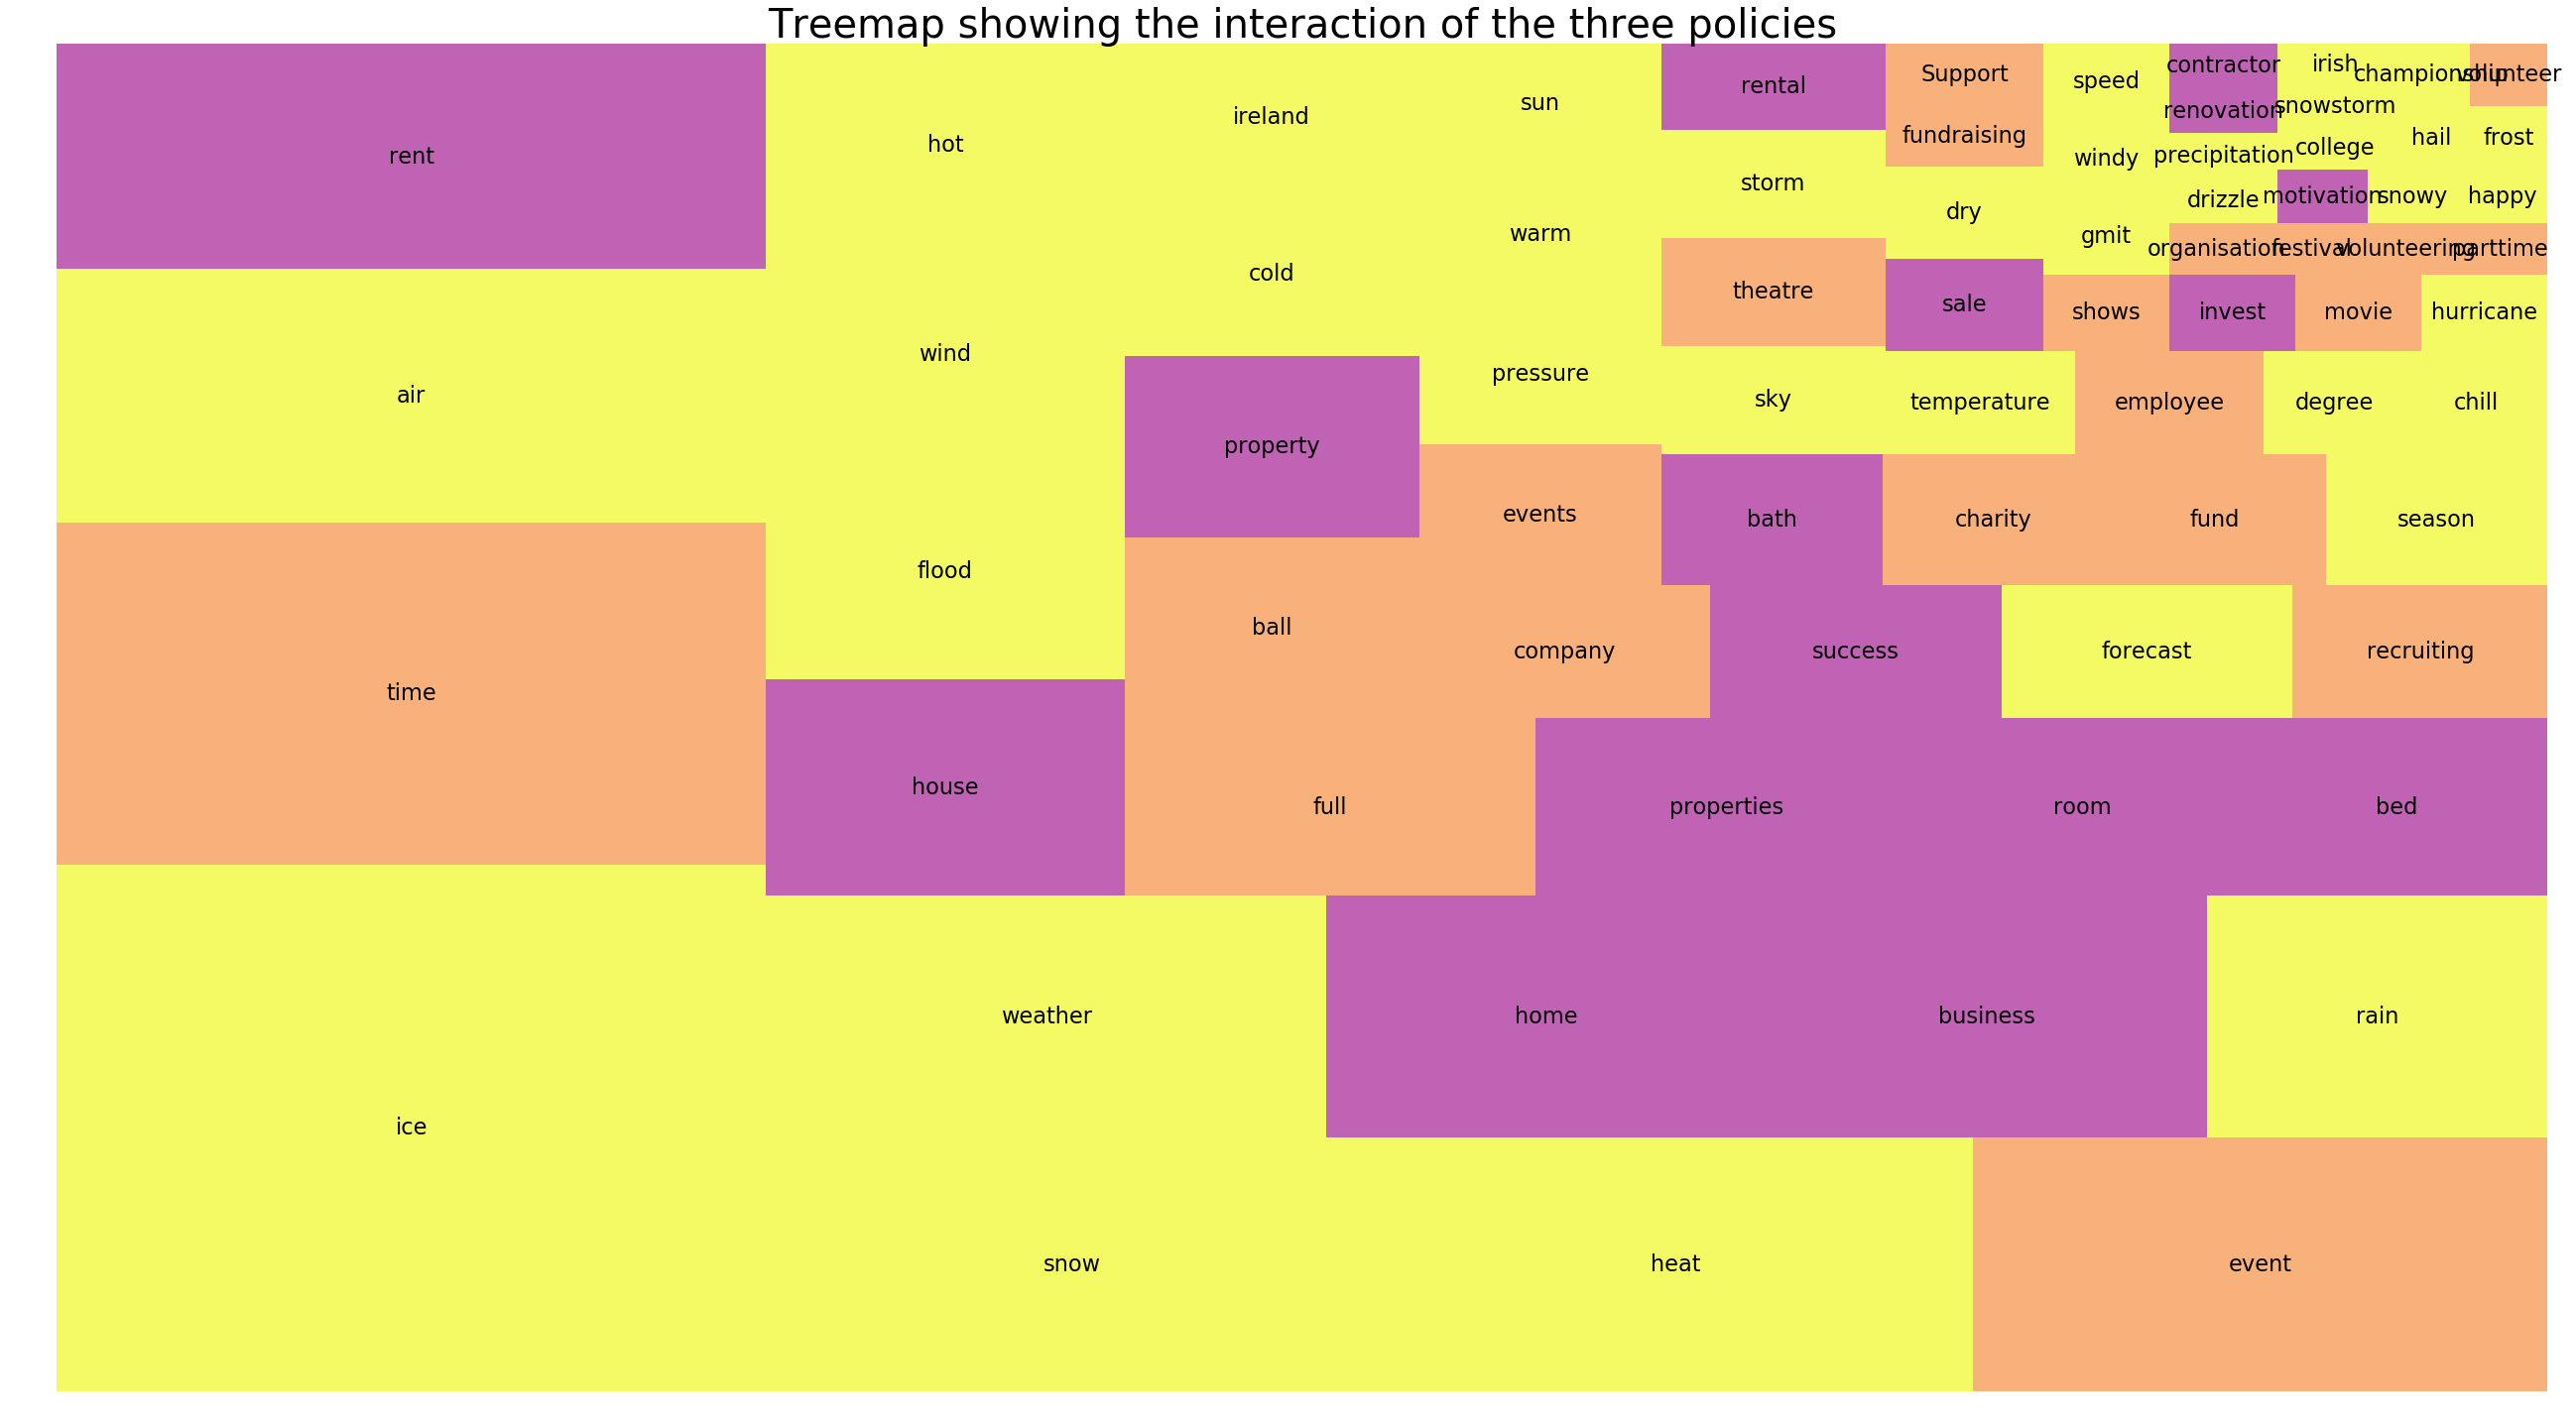

In [7]:
############################################ Riti ########################################################

#for plotting a tree map for visualisation purpose, the classes need to represented as integer value.
#Therefore we have randomly assigned each class to a random number for visualising three different shades of color.
final_table_sorted_fr_treemap=final_table_sorted.replace({'Weather': 500, 'Events':188, 'Housing':94})


#Plotting the treemap for 'Weather Policy' with size as counts of the keywords and label is corresponding keyword. 
#Choosing color palatte
cmap = plt.cm.plasma
colors = [cmap(value) for value in final_table_sorted_fr_treemap.Policy]

#Plotting the visualisation
plt.rc('font', size=22.5)
plt.figure(figsize=(45,25))


squarify.plot(sizes=final_table_sorted_fr_treemap["No_of_Posts_with_Keyword"], label=final_table_sorted_fr_treemap["Keywords"], color=colors, alpha=0.7)

# Mentioning the title of the plot with size
plt.title("Treemap showing the interaction of the three policies", size=40)

plt.axis('off')

plt.show()

### 3. Bar graph

Bar graph below is the representation of number of posts per month for the page.
The data is taken for last six months, that is, from Octobere 2017 to March 2018.

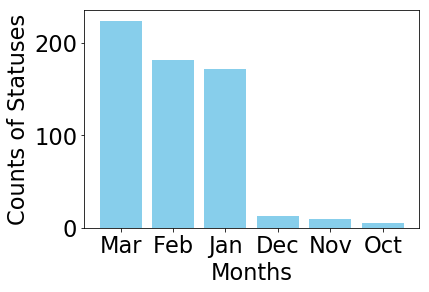

In [8]:
######################################### Shreya #############################################################

# From the dataframe of 'Housing' policy, the rows having 0 counts are dropped using below code.
ph=[]
for i in range(0,len(dframe2)):
        if((dframe2['No_of_Posts_with_Keyword'][i])==0):
            ph.append((dframe2.index[i]))

# dk is the name of dataframe with 0 values dropped.
for k in ph:
    dk=dframe2.drop(dframe2.index[ph])

Count_Weather = sum(dframe1['No_of_Posts_with_Keyword'])
l1=list(dframe1['No_of_Posts_with_Keyword'])
Count_Housing=sum(dframe2['No_of_Posts_with_Keyword'][1:])
l2=list(dframe2['No_of_Posts_with_Keyword'])
# The date formart in the CSV file is YYYY-MM-DD time. To get the month and corresponding name, the folloing code is written
# Fetching date&Time column and converting to list.
f1=FB_data['DateTime'].tolist()
list_month=[]
month_name=[]
month_name_short=[]

# Fetching the digits of the month
for i in range(0,len(f1)):
    list_month.append(f1[i][5:7])
    
#The count of tweets for each month is saved in dictionary with month as key and corresponding count as value
dc = {x:list_month.count(x) for x in list_month}
new_list=[]
for i in dc.keys():
    new_list.append(i)

# Month name is calculated using calendar.month_name function.
for j in range(0,len(new_list)):
    n=int(new_list[j])
    month_name.append(calendar.month_name[n])
    
# Substring month names
for k in range(0,len(month_name)):
    month_name_short.append(month_name[k][0:3])
    
# Plotting the monthwise count of posts
#Mentioning the values of X&y axis
plt.bar(range(len(dc)), dc.values(), align='center', color="skyblue")
plt.xticks(range(len(dc)), month_name_short)

# Mentioning labels and figure size
plt.ylabel('Counts of Statuses')
plt.xlabel('Months')

#Displaying the graph
plt.show()


### 4. Pie Chart

Pie chart is the contribution of each policy towards the total posts fetched from the facebook page for last 6 months.

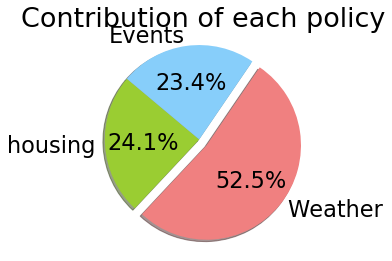

In [9]:
##################################### Shreya ###############################################

# Seperating the policies.
new_dic={}
s_housing=sum(dframe2['No_of_Posts_with_Keyword'][1:])
new_dic.update({'housing':s_housing})
s_Weather=sum(dframe1['No_of_Posts_with_Keyword'])
new_dic.update({'Weather':s_Weather})
s_events=sum(dframe3['No_of_Posts_with_Keyword'])
new_dic.update({'Events':s_events})

# Data Visualization of contribution of policies

# Importning required libraries
import plotly.plotly as py
import plotly.graph_objs as go

# The label od pie chart will be the keys that is name of policy taken from dictionary & Values are the corresponding counts
labels = list(new_dic.keys())
values = list(new_dic.values())
# Explode is used to slice the chart. The lower the value of explode, lower the distance of the slice from the chart
explode = (0.0, 0.1, 0)
# Mentioning the colours of the pie chart
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']

# Plotting the chart
plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
# Mentioning the title
plt.title("Contribution of each policy")
plt.axis('equal')
plt.show()
